In [1]:
import time
import sys, os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import scipy.stats
import tracemalloc
import umap
import hdbscan
import logging
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
logging.captureWarnings(True)
# for Linux only, load font file
# mpl.font_manager.fontManager.addfont("./arial.ttf")

# configure matplotlib
# mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
np.random.seed(42)

In [2]:
def show_logos_cols(prefix, names=None, cols=3, figsize=(8,8), auto_size=True):
    file_list = []
    for img in os.listdir(prefix):
        if img.endswith(".png") == False:
            continue
        if names is not None and fn not in names:
            continue
        file_list.append(img)
    
    file_list_format = []
    for i in file_list:
        try:
            id = int(i.replace("cluster_", "").replace(".png", ""))
        except ValueError:
            id = i.replace("cluster_", "").replace(".png", "")
        file_list_format.append((i, id))
    file_list_format = sorted(file_list_format, key=lambda x:x[1]) 
    
    if len(file_list_format) % cols == 0:
        rows = len(file_list_format) // cols
    else:
        rows = len(file_list_format) // cols + 1
    if auto_size == False:
        figsize = figsize
    else:
        width = 4 * cols
        height = 1.5 * rows
        figsize = (width, height)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if len(file_list_format) > 1:
        for ax, image in zip(*[axes.reshape(-1), file_list_format]):
            fn, id = image
            img = plt.imread(prefix+"/"+fn)
            _ = ax.imshow(img)
            ax.set_title("cluster_{}".format(id))
        for ax in axes.reshape(-1):
            ax.axis("off")
    else:
        image = file_list_format[0]
        fn, id = image
        img = plt.imread(prefix+"/"+fn)
        _ = axes.imshow(img)
        axes.set_title("cluster_{}".format(id))
        axes.axis("off")
    plt.tight_layout()

In [3]:
def simulation(fn):
    # intotal 21 nt
    data = {"TF":{}, "motif_F10": {}}
    df_TF = pd.read_csv(fn, index_col=None, header=0)
    df_TF = df_TF[df_TF["TF"].isin(["Pdx1"])] # NFKB1
    TFs = set(df_TF["TF"].tolist())
    num_of_motifs = [1000] # np.random.randint(50, 5000, len(TFs))
    basespace = df_TF.columns[0:4]
    N = 0
    
    max_len = 50
    
    for TF, sim_num in zip(*[TFs, num_of_motifs]):
        motif_matrix = df_TF[df_TF["TF"] == TF]
        right_max = max_len - motif_matrix.shape[0]
        # pos = np.random.randint(0, right_max)
        rand_dist = np.random.normal(loc=100, scale=200, size=right_max)
        rand_dist = rand_dist - rand_dist.min()
        rand_dist = rand_dist / np.sum(rand_dist)
        rand_dist = np.sort(rand_dist)
        print(rand_dist)
        all_bases = []
        for idx, row in motif_matrix.iterrows():
            all_bases.append(np.random.choice(basespace, sim_num, p=row[basespace]/row[basespace].sum()))
        for i in zip(*all_bases):
            core = "".join(i)
            pos = np.random.choice(range(0,right_max), 
                                   p= rand_dist)
            left = "".join(np.random.choice(basespace, pos)).lower()
            right = "".join(np.random.choice(basespace, max_len - pos - len(core))).lower()
            sim_seq = left + core + right
            data["TF"][N] = TF
            data["motif_F10"][N] = sim_seq.upper()
            N += 1
    # noise 
    #for i in range(9000):
    #    data["TF"][N] = "random_noise"
    #    data["motif_F10"][N] = "".join(np.random.choice(basespace, length))
    #    N += 1
    return pd.DataFrame(data)
    

In [4]:
df = simulation("TFs.csv")

[0.         0.00059495 0.00301068 0.00686034 0.00701994 0.00809874
 0.0094754  0.01037123 0.01156757 0.01214315 0.01348729 0.0174158
 0.01742949 0.01792134 0.01815097 0.01911167 0.01915969 0.01918934
 0.02127101 0.02139169 0.02212964 0.02212985 0.02223708 0.02335941
 0.02364946 0.02495954 0.02599869 0.02655522 0.02733043 0.02765738
 0.02781131 0.0282358  0.02916285 0.02995095 0.03150297 0.03209094
 0.03343921 0.03460343 0.03497495 0.03568173 0.0439295  0.04466541
 0.04538595 0.048888  ]


In [5]:
df

,TF,motif_F10
0,Pdx1,ATACAGGCGTACTATCCTAGGTCAACCTAATTGATGTGCTTCTGAA...
1,Pdx1,ACTGTACATAACGTCGAGAACTAATTCACGGACACCCGCGCGTGGA...
2,Pdx1,TCTTAGCGAGTTCCCACATGTTTCCCGCATTAATTTGGGGGATGTC...
3,Pdx1,AAGACGCTCTGTTCCCGGCGGCTAATGTTCGTAGACGCCCCCGAGG...
4,Pdx1,CTTGGAACCTAATTGGGTCATTTTCGAATTCTAAGGAACCATGATA...
...,...,...
995,Pdx1,CAAGGATGAGCCCGGTCTAACTGTATAATGATCTAATTACGCAGTT...
996,Pdx1,CATGACTGCGGTCCACCTATCAGTAATTTACAAACCATTCGTAGCT...
997,Pdx1,ATGCCTAGGCTACCAGGTCTGAGGCGTACATTGTGCAGGCTGTCTA...
998,Pdx1,AAAGTCCCAAATATTTGCTCTTACTCATATAAGTCTAATTTTCGCT...


In [6]:
df.groupby("TF").count()

,motif_F10
TF,
Pdx1,1000


In [7]:
enc = OneHotEncoder(dtype=np.int8)
enc.fit([[i] for i in "ATCG"])

def onehot_enc(row):
    seq = [[i] for i in row["motif_F10"].upper()]
    return enc.transform(seq).toarray().reshape(-1)

In [8]:
onehot_input = []
for idx, row in df.iterrows():
    onehot_input.append(onehot_enc(row))
onehot_input = np.array(onehot_input)

In [9]:
def draw_one_sample(ax, df, title=None, cluster_col="Cluster", s=0.2, alpha=1.0):
    clusters = list([i for i in range(1, int(df[cluster_col].max())+1)]) + [-1]
    
    for i in clusters:
        subdf = df[df[cluster_col]==i]
        if i == -1:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, c="lightgray", lw=None, label=i)
        else:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, lw=None, label=i)
            c_X = subdf["X"].mean()
            c_Y = subdf["Y"].mean()
            ax.annotate("{}".format(i), xy=(c_X, c_Y), color="k", ha="center", va="center", size=9) # , size=13

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # draw density
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([df["X"], df["Y"]])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")

    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_title(title)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
    return xmin, xmax, ymin, ymax

In [10]:
def UMAP(onehot_input, df, min_dist=0.01, n_neighbors=20, verbose=False, densmap=False, metric='euclidean'):
    df = df.copy()
    # this should takes ~20 sec   
    print("UMAP")
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = umap.UMAP(init="random", random_state=42, n_components=2, min_dist=min_dist, n_neighbors=n_neighbors, verbose=verbose, densmap=densmap, metric=metric)
    umap_output = model.fit_transform(onehot_input)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    
    print("UMAP time: {} sec".format(time1))
    print("UMAP RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = umap_output[:, 0]
    df["Y"] = umap_output[:, 1]
    
    del model
    return time1, mem, df

In [11]:
def cluster_HDBSCAN(df, min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0, cluster_selection_method='eom', draw_condensed_tree=True, soft_clustering=True, optimize=True):
    # use multi-code here
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=cluster_selection_epsilon, cluster_selection_method=cluster_selection_method, core_dist_n_jobs=4, prediction_data=True)
    if optimize == True:
        validity_scorer = make_scorer(hdbscan.validity.validity_index,greater_is_better=True)
        param_dist = {'min_samples': [10, 20,50,100], # 1,
                      'min_cluster_size':[100,200, 300],  
                      'cluster_selection_method' : ['eom'],
                     }
        n_iter_search = 100
        random_search = RandomizedSearchCV(model
                                           ,param_distributions=param_dist
                                           ,n_iter=n_iter_search
                                           ,scoring=validity_scorer 
                                           ,random_state=42)
        random_search.fit(X)
        print(random_search.best_params_)
        model = random_search.best_estimator_
    yhat = model.fit(X)
    
    if soft_clustering == True:
        soft_clusters = hdbscan.all_points_membership_vectors(yhat)
        labels = [np.argmax(x) for x in soft_clusters] 
    else:
        labels = yhat.labels_
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    df["Cluster"] = [i+1 if i > -1 else -1 for i in labels ]  # re-number lables to make it human-readable
    
    print("HDBSCAN soft clustering time: {} sec".format(time1))
    print("HDBSCAN soft clustering RAM: {} Mb".format(mem))
    print("HDBSCAN cluster number: {}".format(df["Cluster"].max()))
    print("==================================================")
    # check cluster number
    print(df.groupby("Cluster")["Cluster"].count())
    
    
    if draw_condensed_tree == True:
        fig, ax = plt.subplots()
        model.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
    return time1, mem, df, model


In [12]:
def extract_fasta_and_draw_motifs(prefix, df, cluster_col="Cluster", filter=None, motif_column="motif_F10", draw_logos=True):
    print("===============  {} ===============".format(prefix))
    if os.path.isdir("{}".format(prefix)) == False:
        os.mkdir("./{}".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    else:
        os.system("rm -r ./{}/*".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    if filter is not None:
        df = df[df[filter] == True].copy()
    clusters = set(df[cluster_col].tolist())
    for g in clusters:
        subdf = df[df[cluster_col] == g]
        with open("./{}/fasta/cluster_{}.fa".format(prefix, g), "w") as output:
            N = 0
            for idx, row in subdf.iterrows():
                output.write(">{}\n{}\n".format(idx, row[motif_column]))  # to RNA bases
                N += 1
            print("Cluster #{}: {}".format(g, N))
    if draw_logos == True:
        for g in clusters:
            os.system("weblogo -A dna -D fasta -F pdf --resolution 1000 --color-scheme classic --composition none -i 0 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A dna -D fasta -F png --resolution 1000 --color-scheme classic --composition none -i 0 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_png/cluster_{g}.png".format(prefix=prefix, g=g))

            os.system("weblogo -A dna -D fasta -F pdf -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i 0 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A dna -D fasta -F png -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i 0 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq_png/cluster_{g}.png".format(prefix=prefix, g=g)) 
            
            os.system("weblogo -A dna -D fasta -X no -Y no -P \"\" -F pdf --resolution 1000 --color-scheme classic --composition none -i 0 -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_no_axis/cluster_{g}.pdf".format(prefix=prefix, g=g))

In [13]:
_, _, df_UMAP = UMAP(onehot_input, df, min_dist=0.01, n_neighbors=20, verbose=False, densmap=False, metric='euclidean')

UMAP
UMAP time: 5.8148839473724365 sec
UMAP RAM: 0.0 MB



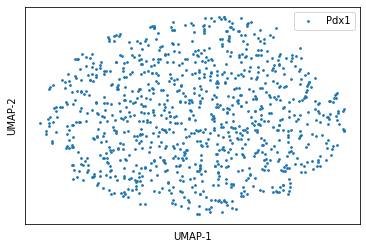

In [14]:
fig, ax = plt.subplots()
for TF in set(df_UMAP["TF"].tolist()):
    if TF != "random_noise":
        subdf = df_UMAP[df_UMAP["TF"] == TF]
        ax.scatter(subdf["X"], subdf["Y"], s=3, label=TF)
    else:
        subdf = df_UMAP[df_UMAP["TF"] == TF]
        ax.scatter(subdf["X"], subdf["Y"], s=3, label=TF, zorder=0, color="lightgray")
plt.legend()
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
plt.savefig("ground_truth.jpg", dpi=300)

{'min_samples': 10, 'min_cluster_size': 100, 'cluster_selection_method': 'eom'}
HDBSCAN soft clustering time: 1.1657395362854004 sec
HDBSCAN soft clustering RAM: 0.0 Mb
HDBSCAN cluster number: -1
Cluster
-1    1000
Name: Cluster, dtype: int64


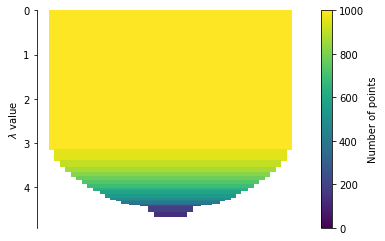

In [15]:
# _, _, df_HDBSCAN, _ = cluster_HDBSCAN(df_UMAP, min_cluster_size=100, min_samples=10, soft_clustering=False, optimize=False)
_, _, df_HDBSCAN, _ = cluster_HDBSCAN(df_UMAP, min_cluster_size=100, min_samples=1, soft_clustering=False, optimize=True)

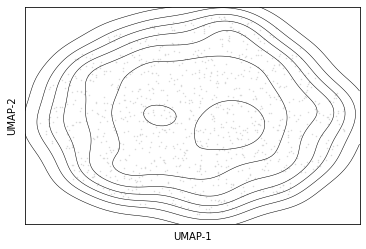

In [16]:
fig, ax = plt.subplots()
draw_one_sample(ax, df_HDBSCAN, title=None, cluster_col="Cluster")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
plt.savefig("HDBSCAN.jpg", dpi=300)

In [33]:
temp = []
wind_size = 30
step = 1
for idx, row in df.iterrows():
    seq = row["motif_F10"]
    for i in range(0, len(seq)-wind_size, step):
        temp.append(seq[i:i+wind_size])

df2 = pd.DataFrame()
df2["motif_F10"] = temp

In [34]:
df2

,motif_F10
0,ATACAGGCGTACTATCCTAGGTCAACCTAA
1,TACAGGCGTACTATCCTAGGTCAACCTAAT
2,ACAGGCGTACTATCCTAGGTCAACCTAATT
3,CAGGCGTACTATCCTAGGTCAACCTAATTG
4,AGGCGTACTATCCTAGGTCAACCTAATTGA
...,...
19995,CTCTAATTGGAAATGCTCCACCTACCCGGA
19996,TCTAATTGGAAATGCTCCACCTACCCGGAT
19997,CTAATTGGAAATGCTCCACCTACCCGGATA
19998,TAATTGGAAATGCTCCACCTACCCGGATAG


In [35]:
onehot_input2 = []
for idx, row in df2.iterrows():
    onehot_input2.append(onehot_enc(row))
onehot_input2 = np.array(onehot_input2)

In [36]:
_, _, df_UMAP2 = UMAP(onehot_input2, df2, min_dist=0.01, n_neighbors=20, verbose=False, densmap=False, metric='euclidean')

UMAP
UMAP time: 10.409209966659546 sec
UMAP RAM: 0.0 MB



HDBSCAN soft clustering time: 0.5845916271209717 sec
HDBSCAN soft clustering RAM: 0.0 Mb
HDBSCAN cluster number: 22
Cluster
-1     9006
 1      770
 2      675
 3      590
 4      605
 5      449
 6      587
 7      589
 8      678
 9      587
 10     671
 11     596
 12     368
 13     337
 14     527
 15     420
 16     371
 17     371
 18     164
 19     540
 20     670
 21     268
 22     161
Name: Cluster, dtype: int64


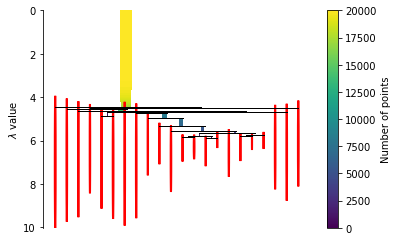

In [37]:
_, _, df_HDBSCAN2, _ = cluster_HDBSCAN(df_UMAP2, min_cluster_size=100, min_samples=100, soft_clustering=False, optimize=False)
# _, _, df_HDBSCAN2, _ = cluster_HDBSCAN(df_UMAP2, min_cluster_size=100, min_samples=1, soft_clustering=False, optimize=True)

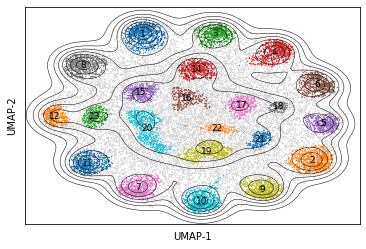

In [38]:
fig, ax = plt.subplots()
draw_one_sample(ax, df_HDBSCAN2, title=None, cluster_col="Cluster")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
plt.savefig("HDBSCAN_sliding.jpg", dpi=300)

In [39]:
extract_fasta_and_draw_motifs("iMVP_out", df_HDBSCAN2)

===============  iMVP_out ===============
Cluster #1: 770
Cluster #2: 675
Cluster #3: 590
Cluster #4: 605
Cluster #5: 449
Cluster #6: 587
Cluster #7: 589
Cluster #8: 678
Cluster #9: 587
Cluster #10: 671
Cluster #11: 596
Cluster #12: 368
Cluster #13: 337
Cluster #14: 527
Cluster #15: 420
Cluster #16: 371
Cluster #17: 371
Cluster #18: 164
Cluster #19: 540
Cluster #20: 670
Cluster #21: 268
Cluster #22: 161
Cluster #-1: 9006


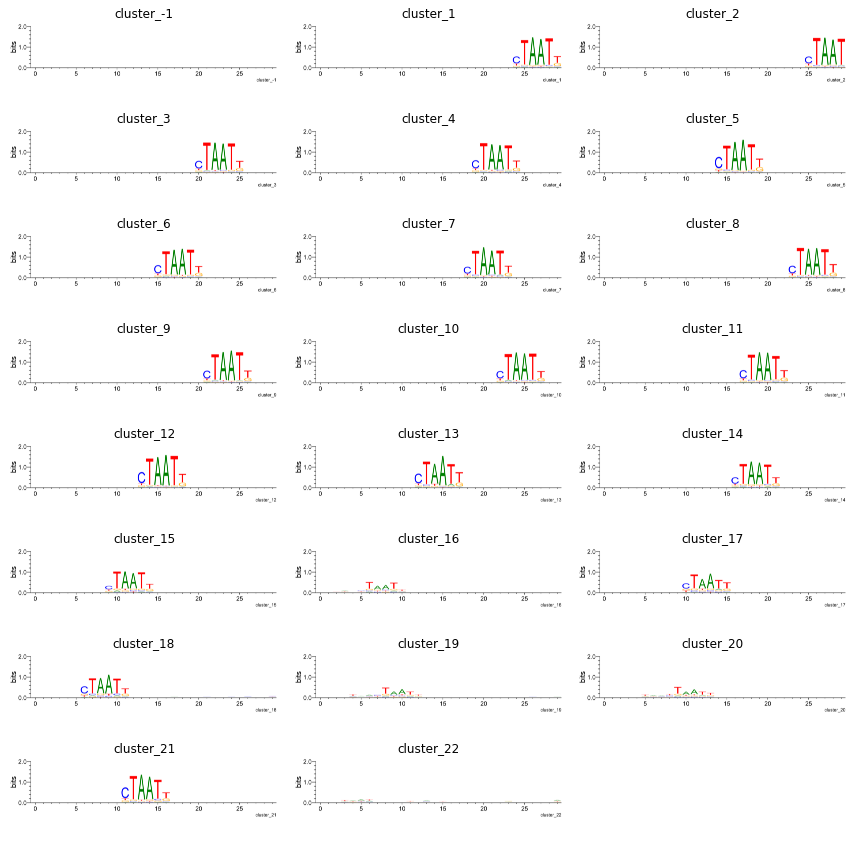

In [40]:
show_logos_cols("./iMVP_out/logos_bits_png/")

In [25]:
with open("sim_out.fa", "w") as output:
    for idx, row in df.iterrows():
        output.write(">{}_{}\n{}\n".format(row["TF"], idx, row["motif_F10"]))

In [ ]:
from weblogo import *

def cal_bits_from_fasta(df, ID, ID_label="Cluster", motif_label="motif_F10", write_output=None):
    subdf = df[df[ID_label]==ID]
    count_data = {}
    for _, row in subdf.iterrows():
        for idx, base in enumerate(list(row[motif_label])):
            if idx not in count_data:
                count_data[idx] = {"A":0, "T":0, "C": 0, "G": 0}
            count_data[idx][base] += 1
    seqs = []
    
    count_df = pd.DataFrame.from_dict(count_data).T
    seqs = count_df.values

    # fin = open(fn)
    #  seqs = read_seq_data(fin)
    seqs = np.array(seqs)
    logodata = LogoData.from_counts(counts=seqs, alphabet='ACGT')

    temp = []
    for i in range(logodata.counts.shape[0]):
        temp.extend(list(logodata.entropy[i]*logodata.counts[i]/logodata.counts[i].sum()))
        if write_output is not None:
            write_output.write("{}\t{}\t{}\t{}\n".format(logodata.counts[i][0], logodata.counts[i][1], logodata.counts[i][2], logodata.counts[i][3]))
    write_output.write("\n")
    # reorder
    temp2 = temp[::4] + temp[1::4] + temp[2::4] + temp[3::4]
    return np.array(temp2)

with open("temp.mat", "a") as count_mat_file:
    temp = []
    for i in [1,2,3,4,5,6,7,8]:
        temp.append(cal_bits_from_fasta(df_HDBSCAN, i, write_output=count_mat_file))

'''
m1 = cal_bits_from_fasta("./iMVP_out/fasta/cluster_1.fa")
m2 = cal_bits_from_fasta("./iMVP_out/fasta/cluster_2.fa")
m3 = cal_bits_from_fasta("./iMVP_out/fasta/cluster_3.fa")
m4 = cal_bits_from_fasta("./iMVP_out/fasta/cluster_4.fa")
m5 = cal_bits_from_fasta("./iMVP_out/fasta/cluster_5.fa")
'''

In [ ]:
!matrix2meme -dna < temp.mat > temp.meme

In [ ]:
!tomtom -oc tomtom_out temp.meme temp.meme

In [ ]:
df_motif_sim = pd.read_table("./tomtom_out/tomtom.tsv", index_col=None, header=0, comment="#")

In [ ]:
df_motif_sim

In [ ]:
df_motif_sim_pivot = df_motif_sim.pivot(index="Query_ID", columns="Target_ID", values="q-value")
df_motif_sim_pivot[df_motif_sim_pivot==0] = 1e-10

In [ ]:
from matplotlib.colors import LogNorm, Normalize
sns.heatmap(data=df_motif_sim_pivot, square=True, norm=LogNorm(), vmax=0)

In [ ]:
fig, axes = plt.subplots(len(temp),1,sharey=True)
for idx, item in enumerate(temp):
    axes[idx].plot(item)